# Week 7 of Introduction to Biological System Design
## Stochastic Systems and Simulations
### Ayush Pandey

Pre-requisite: To get the best out of this notebook, make sure that you have basic understanding of probability distributions. For more information on probability theory you may refer to any standard book on engineering math. The notebook uses ODE models to evaluate stochasticity effects as well. You can learn more about how to numerically simulate ODEs deterministically from the [week3_intro_ode.ipynb](https://pages.hmc.edu/pandey/reading/week3_intro_ode.ipynb) notebook. Further, it is also assumed that you have a working knowledge of gene expression processes, use of Hill functions for gene regulation, and biological system motifs. Computational examples with Hill functions are discussed in [week4_hill_functions.ipynb](https://pages.hmc.edu/pandey/reading/week4_hill_functions.ipynb) whereas design choices underlying biological motifs are shown in [week6_system_analysis.ipynb](https://pages.hmc.edu/pandey/reading/week6_system_analysis.ipynb).

This notebook presents stochatic simulations of biological systems and processes such as cell division, gene expression and gene regulation. The physical effects of randomness and noise in these simulations is also alluded to in the notebook with the help of examples.

# Stochastic Cell Division

Consider a mother cell with $N$ molecules which divides into two daughter cells with $n_1$ and $n_2$ molecules. Let the probability of a molecule being in daughter 1 be given by $p$ and the probability of a molecule in daughter 2 be $q$. Then, we have $p + q = 1$. The probability distribution that models this "random" cell division is called the Binomial distribution and is given by,

$ \mathbb{P}(n_1, N) = \left(\begin{matrix}N \\ n_1\end{matrix}\right) p^{n_1} q^{N - n_1}$ 

where $\left(\begin{matrix}N \\ n_1\end{matrix}\right)$ represents "$N$ choose $n_1$", that is the number of possibilities of choosing $n_1$ molecules from $N$ total. 

The binomial distribution is a simplest stochastic model of cell division but can be effectively used to model cell lineage growth. To simulate this process, we can take a "Monte Carlo Sampling" approach, where we simulate the binomial distribution such that for every molecule we draw a random sample and propagate its place in one of the daughter cells, and so on. 

The mean of the binomial distribution is given by $\mu = Np$ and the variance is given by $\sigma^2 = Npq$. The coefficient of variation (CV) can be used to determine the variation from the mean and is given by $\sigma/\mu$. If CV is low, a deterministic approximation may work fine but for high CV, we need to simulate the system stochastically. 

Let us use Python to run a stochastic model of cell division:

## Using binomial distribution for cell division

### Simulate coin flips

In [12]:
import numpy as np

n, p = 10, .5  # number of trials, probability of each trial

s = np.random.binomial(n, p, 1000)
# result of flipping a coin 10 times, tested 1000 times.

In [14]:
# Print out s to see the samples
# s

### Simulate cell division with N = 100 molecules

In [28]:
p = 0.5 # probability of each molecule to go to daughter 1
N = 100 #number of molecules in each cell
number_of_cells = 20
daughter_1_cells = np.random.binomial(N, p, number_of_cells)
q = 1 - p
daughter_2_cells = np.random.binomial(N, q, number_of_cells)

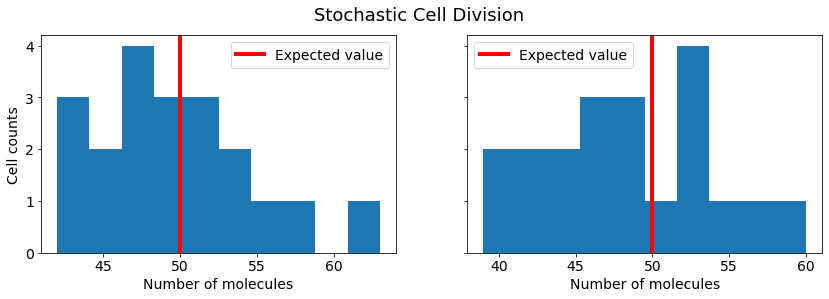

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize = (14,4), sharey = True)
fig.suptitle('Stochastic Cell Division', fontsize = 18)
ax[0].hist(daughter_1_cells)
ax[0].axvline(N*p, color = 'red', lw = 4, label = 'Expected value')
ax[0].set_xlabel('Number of molecules', fontsize = 14)
ax[0].set_ylabel('Cell counts', fontsize = 14)
ax[0].tick_params(labelsize = 14)
ax[0].legend(fontsize = 14)

ax[1].hist(daughter_2_cells)
ax[1].axvline(N*q, color = 'red', lw = 4, label = 'Expected value')
ax[1].set_xlabel('Number of molecules', fontsize = 14)
ax[1].tick_params(labelsize = 14)
ax[1].legend(fontsize = 14);

In [30]:
def divide_cell(N, p):
    """
    Given a cell with N molecules, divide it 
    into two daughter cells according to Binomial
    distribution with probability p
    """
    d1 = np.random.binomial(N, p)
    d2 = N - d1
    return d1, d2

N0 = 1 # start with 1 cell
generations = 20 # cell division cycles
d1 = np.zeros(generations)
d2 = np.zeros(generations)
for g in range(generations):
    d1[g], d2[g] = divide_cell(N, p)

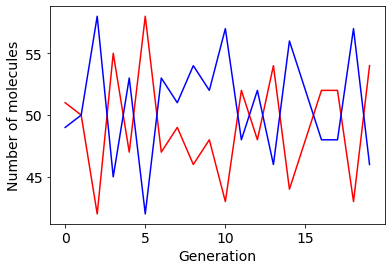

In [31]:
ax = plt.axes()
ax.plot(d1, 'r')
ax.plot(d2, 'b')
ax.set_ylabel('Number of molecules', fontsize = 14)
ax.set_xlabel('Generation', fontsize = 14)
ax.tick_params(labelsize = 14)

# Stochastic Simulation Algorithm (SSA)

It is often the case that the analytical probability distribution of processes is unknown. In such cases, quantifying the stochastic behavior can be challenging. Stochastic simulation algorithms are built to simulate system descriptions (rate equations, chemical reactions, etc.) in a stochastic manner. We will build a very basic stochastic simulator in this notebook to simulate gene expression. For an unregulated gene, we can write a one-state model:

$\frac{dX}{dt} = k - dX$

In deterministic simulations, we assume that the number of molecules of $X$ are high enough so that we can approximate its dynamics by modeling the concentration. However, in reality, we have the count of molecules of $X$ which is increasing or decreasing stochastically. So, let us model the unregulated gene expression by using number of molecules of $X$ as our state variable. 

Let $\mathbb{P}(X,t)$ be the probability that there are $X$ molecules of protein $X$ at time $t$. We define that this probability will be equal to zero if $X < 0$. For $X > 0$, we can write the following for change in $X$:

$X - 1 \rightarrow X$, propensity = $k$,

$X + 1 \rightarrow X$, propensity = $d(X+1)$,

$X \rightarrow X + 1$, propensity = $k$,

$X \rightarrow X - 1$, propensity = $dX$.

The propensity defines the transition probability, that is, the probability of transitioning from $X$ molecules to $X+1$ molecules is given by the rate $k$, similarly, to degrade from $X$ to $X - 1$, we have the transition probability defined as $dX$. 

We can then define the following equation for change of probability of the number of protein molecules $X$ at time $t$,

$\frac{d\mathbb{P}(X, t)}{dt} = k\mathbb{P}(X-1, t) + d  (X + 1)  \mathbb{P}(X+1, t) - k\mathbb{P}(X, t) - d  X  \mathbb{P}(X, t)$

The first two terms define the ways in which we get to the microstate with $X$ molecules and the last two terms define the ways in which we transition out of the microstate with $X$ molecules. 

To run a dry stochastic simulation, we can use the Monte Carlo sampling technique to run a stochastic simulation as follows

### Monte Carlo Sampling based stochastic simulation

In [3]:
import numpy as np
time_max = 100 # the time for which we want to run the simulation
dt = 1 # the time step 
total_points = int(time_max/dt)
k = 0.4
d = 0.1
prob_exp = k
prob_deg = d
# Initial conditions
X0 = 0

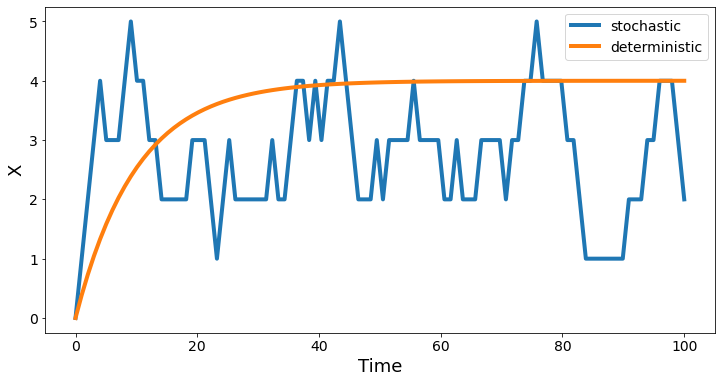

In [4]:
T = np.zeros(total_points)
X = np.zeros(total_points)
timepoints = np.linspace(0, time_max, total_points)
# Enumerate over time points to simulate for each time point
for i,t in enumerate(timepoints):
    # Sample the propensities randomly
    k_s = np.random.rand()
    d_s = np.random.rand()

    # For the 0th index
    if i == 0:
        if k_s < k:
            X[0] = X0
        continue
    # Monte-Carlo simulation
    if k_s < k:
        # Increase previous count by 1
        X[i] = X[i-1] + 1
    else:
        # Same as before
        X[i] = X[i-1]
        
    if d_s < d*X[i-1]:
        # Decrease previous count by 1
        X[i] = X[i-1] - 1
    else:
        # Do nothing
        X[i] = X[i]

# Simulate deterministic
def unregulated(x, t, *args):
    return k - d*x
from scipy.integrate import odeint
X_deterministic = odeint(unregulated, 0, timepoints, args = (k,d))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(timepoints, X, lw = 4, label = 'stochastic')
ax.plot(timepoints, X_deterministic, lw = 4, label = 'deterministic')
ax.set_xlabel('Time', fontsize = 18)
ax.set_ylabel('X', fontsize = 18)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14);

# Optional (advanced) Content:

### Gillespie SSA

Simulation of the equation given above can be done using an algorithm proposed by Gillespie in 1976. This algorithm is now called Gillespie's SSA. Gillespie SSA simulates each reaction firing at its given propensity as a Poisson process. The reasoning behind this is that the each reaction has a waiting time before it can be fired, and that waiting time is dependent on the propensity of the reaction. This kind of probability distribution is described by a Poisson process. The detailed steps and the proof of the Gillespie SSA algorithm are beyond the scope of this course. So, you can read more about Poisson process and the Gillespie algorithm in detail [here](https://www.sciencedirect.com/science/article/pii/0021999176900413?via%3Dihub) and in BFS Chapter 4. 

A detailed implementation of Gillespie SSA can be found in [this notebook](https://biocircuits.github.io/chapters/14_stochastic_simulation.html) by Justin Bois. But, since we are not going into the details of the Gillespie SSA algorithm, we will use a packaged implementation of the SSA algorithm. There are many Python packages that provide such an implementation such as [biocircuits](https://github.com/justinbois/biocircuits), [bioscrape](https://github.com/biocircuits/bioscrape/), [COPASI](http://copasi.org/), and quite a few others. 

Since we will use [bioscrape](https://github.com/biocircuits/bioscrape/) for parameter inference lectures later on as well, we use the same package for stochastic simulations here.

In [5]:
!pip install bioscrape

In [6]:
from bioscrape.simulator import py_simulate_model
from bioscrape.types import Model

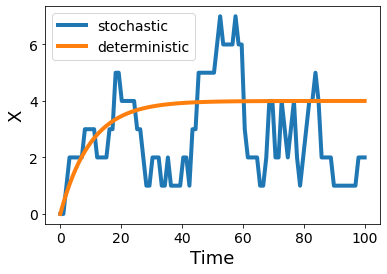

In [8]:
species = ['X']
params = [('k', k), ('d', d)]
r1 = ([], ['X'], 'massaction', {'k':'k'})
r2 = (['X'], [], 'massaction', {'k':'d'})
initial_conditions = {'X':0}
unregulated_expr = Model(species = species, reactions = [r1, r2],
                         parameters = params, 
                         initial_condition_dict = initial_conditions)
results_stoch = py_simulate_model(Model = unregulated_expr, 
                                  timepoints = timepoints, 
                                  stochastic = True)
results_det = py_simulate_model(Model = unregulated_expr, 
                                timepoints = timepoints, 
                                stochastic = False)
ax = plt.axes()
ax.plot(timepoints, results_stoch['X'], lw = 4, label = 'stochastic')
ax.plot(timepoints, results_det['X'], lw = 4, label = 'deterministic')
ax.set_xlabel('Time', fontsize = 18)
ax.set_ylabel('X', fontsize = 18)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14);

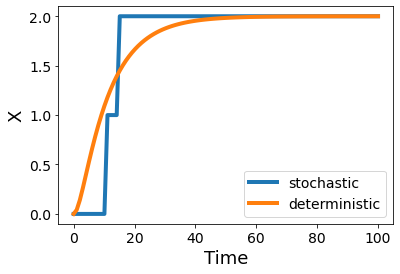

In [11]:
species = ['T', 'X']
params = [('k_tx', 1), ('d_T', 0.5), ('k_tl', 0.1), ('d_X', 0.1)]
r0 = ([], ['T'], 'general', {'rate':'k_tx - d_T*T'})
r1 = ([], ['X'], 'general', {'rate':'k_tl*T - d_X*X'})
initial_conditions = {'T':0, 'X':0}
unregulated_expr = Model(species = species, reactions = [r0, r1],
                         parameters = params, 
                         initial_condition_dict = initial_conditions)
results_stoch = py_simulate_model(Model = unregulated_expr, 
                                  timepoints = timepoints, 
                                  stochastic = True)
results_det = py_simulate_model(Model = unregulated_expr, 
                                timepoints = timepoints, 
                                stochastic = False)
ax = plt.axes()
ax.plot(timepoints, results_stoch['X'], lw = 4, label = 'stochastic')
ax.plot(timepoints, results_det['X'], lw = 4, label = 'deterministic')
ax.set_xlabel('Time', fontsize = 18)
ax.set_ylabel('X', fontsize = 18)
ax.tick_params(labelsize = 14)
ax.legend(fontsize = 14);

The general propensity does not really capture the stochastic effects correctly and the reason for that is in the details of how the Gillespie SSA works. In a nutshell, Gillespie SSA requires each reaction to be modeled separately so that its firing propensity is simulated correctly. With a general propensity, the rates are merged together and so what we are seeing is quite similar to the deterministic simulation. If we instead use particular propensities for each reaction, we will get a much better stochastic simulation. 